This runs all segmentation operations in one place.
The idea is that this should be faster and easier to envoke as we only have to load the image data once instead of N times (~10).
Running each individual task as its own script is modular but requires overhead to load the data each time.
Currently it takes about 15 minutes to complete a single organoid's segmentation for all compartments... (~50,1500,1500) (Z,Y,X) dimensional image. 
Let us see how long this takes!

No we are at ~8 minutes!

In [1]:
import argparse
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from file_reading import *
from file_reading import read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from organoid_segmentation import *
from segmentation_decoupling import *
from skimage.filters import sobel

In [2]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [3]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [4]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "C4-1"
    clip_limit = 0.01
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


window_size = 2
input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


In [5]:
return_dict = read_in_channels(
    find_files_available(input_dir),
    channel_dict={
        "nuclei": "405",
        "cyto1": "488",
        "cyto2": "555",
        "cyto3": "640",
        "brightfield": "TRANS",
    },
    channels_to_read=["cyto2"],
)
cyto2_raw = return_dict["cyto2"]
del return_dict
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
nuclei_mask = read_zstack_image(nuclei_mask_output)
# run clip_limit here
cyto2 = skimage.exposure.equalize_adapthist(
    cyto2_raw, clip_limit=clip_limit, kernel_size=None
)
del cyto2_raw

## Segment the cells

In [6]:
def segment_cells_with_3D_watershed(
    cyto_signal: np.ndarray,
    nuclei_mask: np.ndarray,
    connectivity: int = 3,
    compactness: float = 0.0,
) -> np.ndarray:
    # gaussian filter to smooth the image
    # cell_signal_image = skimage.filters.gaussian(cyto_signal, sigma=1.0)
    # scale the pixels to max 255
    # nuclei_mask = (nuclei_mask / nuclei_mask.max() * 255).astype(np.uint8)
    # generate the elevation map using the Sobel filter
    # elevation_map = sobel(cell_signal_image)

    # Option A: Distance transform (often better for cell separation)
    # elevation_map = scipy.ndimage.distance_transform_edt(cell_signal_image > threshold)
    # elevation_map = elevation_map.max() - elevation_map  # Invert

    # # Option B: Gradient magnitude (stronger edges)
    # elevation_map = skimage.filters.scharr(cell_signal_image)
    # set up seeded watersheding where the nuclei masks are used as seeds
    # note: the cytoplasm is used as the signal for this.

    labels = skimage.segmentation.watershed(
        image=cyto_signal,
        markers=nuclei_mask,
        connectivity=connectivity,  # 26-connectivity for 3D
        compactness=compactness,  # higher values make segments more compact
    )

    # change the largest label (by area) to 0
    # cleans up the output and sets the background properly
    unique, counts = np.unique(labels, return_counts=True)
    largest_label = unique[np.argmax(counts)]
    labels[labels == largest_label] = 0
    cell_mask = labels.copy()
    # cell_mask = run_post_hoc_refinement(
    #     mask_image=cell_mask,
    #     sliding_window_context=3,
    # )
    return labels

In [7]:
cmap_option = "magma"

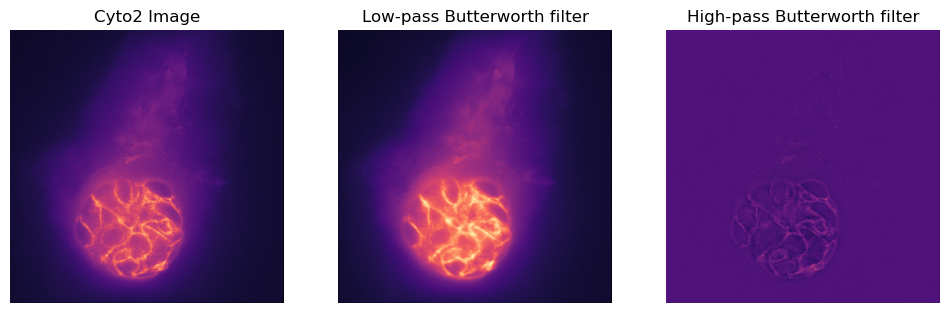

In [8]:
elevation_map_1 = skimage.filters.butterworth(
    cyto2,
    cutoff_frequency_ratio=0.08,
    order=2,
    high_pass=False,
    squared_butterworth=False,
)
elevation_map_2 = skimage.filters.butterworth(
    cyto2,
    cutoff_frequency_ratio=0.08,
    order=2,
    high_pass=True,
    squared_butterworth=False,
)
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.imshow(cyto2[cyto2.shape[0] // 2], cmap=cmap_option)
plt.title("Cyto2 Image")
plt.axis("off")
plt.subplot(132)
plt.imshow(elevation_map_1[cyto2.shape[0] // 2], cmap=cmap_option)
plt.title("Low-pass Butterworth filter")
plt.axis("off")
plt.subplot(133)
plt.imshow(elevation_map_2[cyto2.shape[0] // 2], cmap=cmap_option)
plt.title("High-pass Butterworth filter")
plt.axis("off")
plt.show()

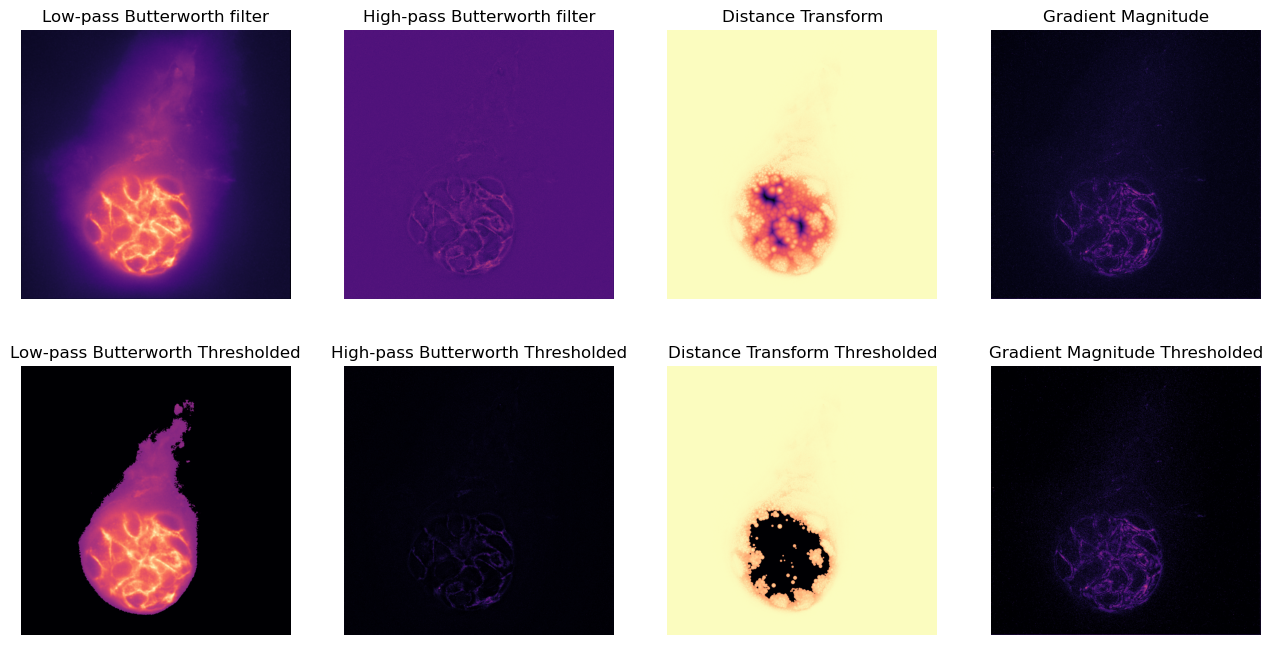

In [9]:
threshold_1 = skimage.filters.threshold_otsu(elevation_map_1)

# Option A: Distance transform (often better for cell separation)
elevation_map_3 = scipy.ndimage.distance_transform_edt(cyto2 > threshold_1)
elevation_map_3 = elevation_map_3.max() - elevation_map_3  # Invert
# Option B: Gradient magnitude (stronger edges)
elevation_map_4 = skimage.filters.scharr(cyto2)

threshold_2 = skimage.filters.threshold_otsu(elevation_map_2)
threshold_3 = skimage.filters.threshold_otsu(elevation_map_3)
threshold_4 = skimage.filters.threshold_otsu(elevation_map_4)
threshold_5 = skimage.filters.threshold_otsu(cyto2)

# apply the thresholds to each elevation map
elevation_map_1_threshold_1 = elevation_map_1 > threshold_1
elevation_map_2_threshold_2 = elevation_map_2 > threshold_2
elevation_map_3_threshold_3 = elevation_map_3 > threshold_3
elevation_map_4_threshold_4 = elevation_map_4 > threshold_4

elevation_map_1_threshold_1_signal = elevation_map_1.copy()
elevation_map_2_threshold_2_signal = elevation_map_2.copy()
elevation_map_3_threshold_3_signal = elevation_map_3.copy()
elevation_map_4_threshold_4_signal = elevation_map_4.copy()

elevation_map_1_threshold_1_signal[elevation_map_1_threshold_1 == False] = 0
elevation_map_2_threshold_2_signal[elevation_map_2_threshold_2 == False] = 0
elevation_map_3_threshold_3_signal[elevation_map_3_threshold_3 == False] = 0
elevation_map_4_threshold_4_signal[elevation_map_4_threshold_4 == False] = 0

z_slice_to_display = cyto2.shape[0] // 2
plt.figure(figsize=(16, 8))
plt.subplot(241)
plt.imshow(elevation_map_1[z_slice_to_display], cmap=cmap_option)
plt.title("Low-pass Butterworth filter")
plt.axis("off")
plt.subplot(242)
plt.imshow(elevation_map_2[z_slice_to_display], cmap=cmap_option)
plt.title("High-pass Butterworth filter")
plt.axis("off")
plt.subplot(243)
plt.imshow(elevation_map_3[z_slice_to_display], cmap=cmap_option)
plt.title("Distance Transform")
plt.axis("off")
plt.subplot(244)
plt.imshow(elevation_map_4[z_slice_to_display], cmap=cmap_option)
plt.title("Gradient Magnitude")
plt.axis("off")
plt.subplot(245)
plt.imshow(elevation_map_1_threshold_1_signal[z_slice_to_display], cmap=cmap_option)
plt.title("Low-pass Butterworth Thresholded")
plt.axis("off")
plt.subplot(246)
plt.imshow(elevation_map_2_threshold_2_signal[z_slice_to_display], cmap=cmap_option)
plt.title("High-pass Butterworth Thresholded")
plt.axis("off")
plt.subplot(247)
plt.imshow(elevation_map_3_threshold_3_signal[z_slice_to_display], cmap=cmap_option)
plt.title("Distance Transform Thresholded")
plt.axis("off")
plt.subplot(248)
plt.imshow(elevation_map_4_threshold_4_signal[z_slice_to_display], cmap=cmap_option)
plt.title("Gradient Magnitude Thresholded")
plt.axis("off")
plt.show()

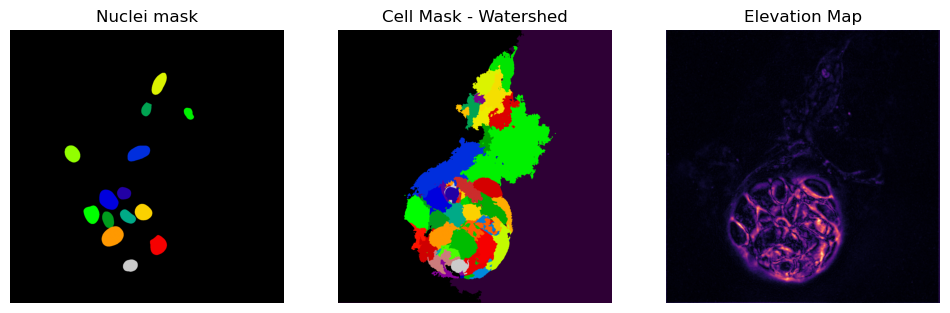

In [10]:
# # set up proper distance transform and gradient descent parameters
# cell_signal_image = skimage.filters.gaussian(cyto2, sigma=1.0)
# elevation_map = skimage.filters.sobel(cell_signal_image)
# nuclei_mask_scaled = skimage.measure.label(nuclei_mask > 0)
# nuclei = nuclei_mask_scaled
nuclei = nuclei_mask
# # remove background marker
# # get the markers
# elevation_map = elevation_map_1
# labels = skimage.segmentation.watershed(
#     image=elevation_map,
#     markers=nuclei_mask,
#     # connectivity=1
# )
# unique, counts = np.unique(labels, return_counts=True)
# largest_label = unique[np.argmax(counts)]
# print(f"Largest label to remove: {largest_label}")
# labels[labels == largest_label] = 0

# cyto_signal=cyto2
cyto_signal = elevation_map_1
# cyto_signal=elevation_map_2
# cyto_signal=elevation_map_3
# cyto_signal=elevation_map_4
# apply a gaussian filter
cyto_signal = skimage.filters.gaussian(cyto_signal, sigma=1)
cyto_signal = sobel(cyto_signal)
# nuclei = skimage.morphology.erosion(
#     nuclei > 0,
#     skimage.morphology.ball(1)
# )
# nuclei = skimage.measure.label(nuclei)

cell_mask = segment_cells_with_3D_watershed(
    cyto_signal=cyto_signal,
    nuclei_mask=nuclei,
    connectivity=1,  # ranges from 1 to 3
    compactness=0,  # lower values lead to more detailed shapes
)
# for z in range(cyto2.shape[0]):
z = cyto2.shape[0] // 2
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title("Nuclei mask")
plt.imshow(nuclei[z], cmap="nipy_spectral")
plt.axis("off")
plt.subplot(132)
plt.title("Cell Mask - Watershed")
plt.imshow(cell_mask[z], cmap="nipy_spectral")
plt.axis("off")
plt.subplot(133)
plt.title("Elevation Map")
plt.imshow(cyto_signal[z], cmap=cmap_option)
plt.axis("off")
plt.show()

## Save the segmented masks

In [11]:
# nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
cell_mask_output = pathlib.Path(f"{mask_path}/cell_mask.tiff")
# cytoplasm_mask_output = pathlib.Path(f"{mask_path}/cytoplasm_mask.tiff")
# organoid_mask_output = pathlib.Path(f"{mask_path}/organoid_mask.tiff")
# tifffile.imwrite(nuclei_mask_output, nuclei_mask)
tifffile.imwrite(cell_mask_output, cell_mask)
# tifffile.imwrite(cytoplasm_mask_output, cytoplasm_mask)
# # tifffile.imwrite(organoid_mask_output, organoid_mask)

In [12]:
# end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
# end_time = time.time()
# print(f"""
#     Memory and time profiling for the run:\n
#     Memory usage: {end_mem - start_mem:.2f} MB\n
#     Time:\n
#     --- %s seconds --- % {(end_time - start_time)}\n
#     --- %s minutes --- % {((end_time - start_time) / 60)}\n
#     --- %s hours --- % {((end_time - start_time) / 3600)}
# """)